## Checklist

* Loads data from the original source on the web 
* Wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
* Performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
* Creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
* Performs the data analysis
* Creates a visualization of the analysis


note: all tables and figure should have a figure/table number and a legend

In [2]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(dplyr)
library(tidyclust)
library(repr)
library(GGally)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [3]:
data <- read_excel('data/heart_disease.xlsx')
head(data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


In [17]:
heart_data <- data|> 
    rename(diagnosis = num) |> #Renames num to Diagnosis
    mutate(ca = as.numeric(ca), thal = as.numeric(thal), diagnosis = as.factor(diagnosis)) |> #Formats table
    na.omit()

head(heart_data)

heart_data_clean <- heart_data |>
    select(age, trestbps, chol, thalach, oldpeak, thal, diagnosis)

head(heart_data_clean)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


age,trestbps,chol,thalach,oldpeak,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,6,0
67,160,286,108,1.5,3,2
67,120,229,129,2.6,7,1
37,130,250,187,3.5,3,0
41,130,204,172,1.4,3,0
56,120,236,178,0.8,3,0


In [29]:
summary_table <- heart_data_clean |>
      group_by(diagnosis) |>
      summarise(across(where(is.numeric), list(mean = ~mean(.x, na.rm = TRUE))),
            Count = n())

summary_table

diagnosis,age_mean,trestbps_mean,chol_mean,thalach_mean,oldpeak_mean,thal_mean,Count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,52.64375,129.1750,243.4938,158.5813,0.598750,3.787500,160
1,55.61111,133.2778,249.1481,145.9815,1.022222,5.314815,54
2,58.20000,134.3714,260.8571,135.0000,1.802857,6.028571,35
3,56.00000,135.4571,246.4571,132.0571,1.962857,6.285714,35
4,59.69231,138.7692,253.3846,140.6154,2.361538,6.230769,13


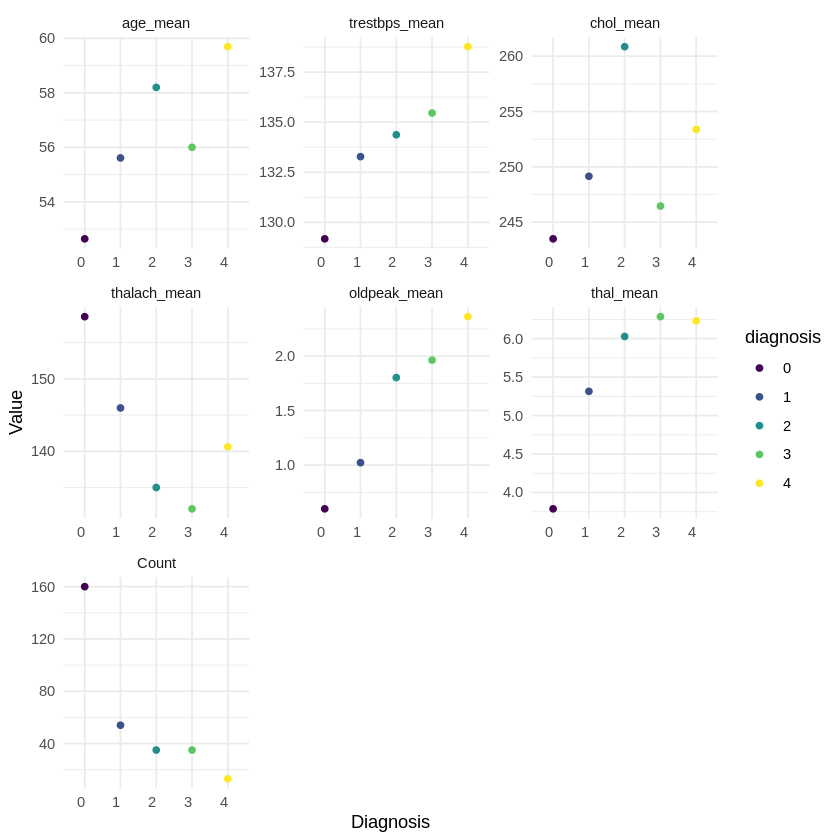

In [28]:
st_long <- reshape2::melt(summary_table, id.vars = 'diagnosis')

summary_plot <- ggplot(st_long, aes(x = diagnosis, y = value, color = diagnosis)) +
  geom_point() + 
  facet_wrap(variable ~., scales = "free") + 
  labs(x = "Diagnosis", y = "Value") +
  theme_minimal() +
  theme(
    strip.text.x = element_text(angle = 0, hjust = 0.5),
    axis.text.x = element_text(angle = 0, hjust = 1)
  ) +
  scale_color_viridis_d()

summary_plot

In [30]:
set.seed(9998)
heart_split <- initial_split(heart_data_clean, prop = 0.80, strata = diagnosis)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

heart_train |>
    slice(0:5)
heart_test |> 
    slice(0:5)

age,trestbps,chol,thalach,oldpeak,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,6,0
37,130,250,187,3.5,3,0
41,130,204,172,1.4,3,0
56,120,236,178,0.8,3,0
57,120,354,163,0.6,3,0


age,trestbps,chol,thalach,oldpeak,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
44,120,263,173,0.0,7,0
52,172,199,162,0.5,7,0
64,110,211,144,1.8,3,0
58,132,224,173,3.2,7,3
64,140,335,158,0.0,3,1


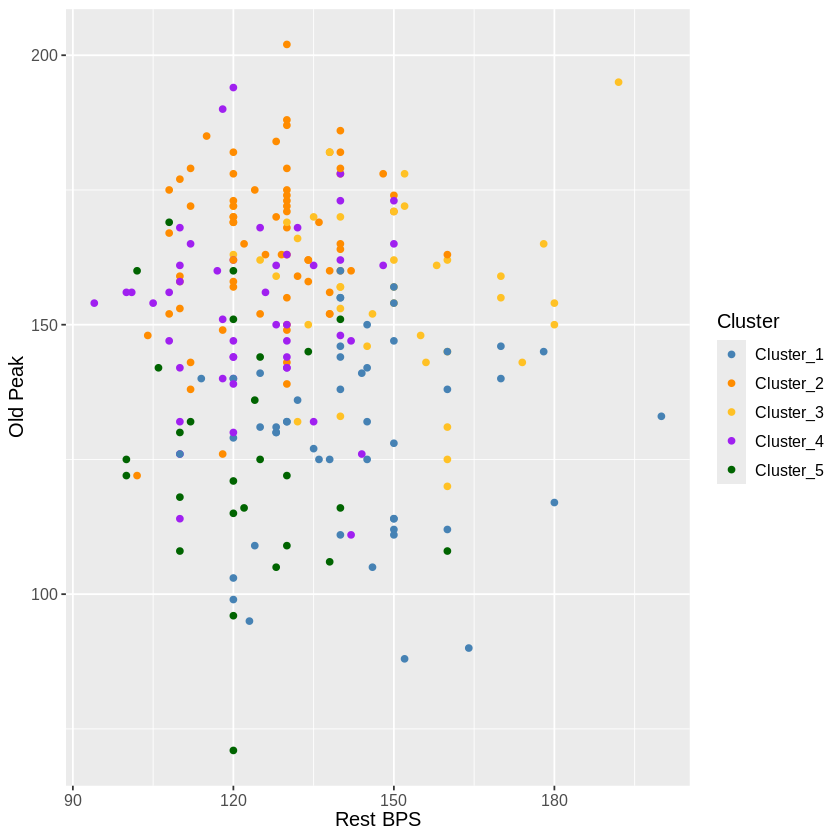

In [35]:
set.seed(9998)
# Cross-Validation
heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

# KNN Steps
heart_recipe <- recipe( ~ ., data = heart_train) |>
    step_rm(diagnosis) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- k_means(num_clusters = 5) |>
    set_engine("stats")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    fit(data = heart_train)

clustered_data <- heart_fit |>
    augment(new_data = heart_train)

cluster_plot <- ggplot(clustered_data,
  aes(x = trestbps,
      y = thalach,
      color = .pred_cluster),
  size = 2) +
  geom_point() +
  labs(x = "Rest BPS",
       y = "Old Peak",
       color = "Cluster") +
  scale_color_manual(values = c("steelblue",
                                "darkorange",
                                "goldenrod1",
                                "purple",
                                "darkgreen")) +
  theme(text = element_text(size = 12))

cluster_plot 